In [1]:
from pattern import web 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re

%matplotlib inline 

In [2]:
# load data

f = open('allxml.pckl', 'rb')
allxml = pickle.load(f)
f.close()

f = open('allsummary.pckl', 'rb')
summary = pickle.load(f)
f.close()

f = open('allIF.pckl', 'rb')
IF_dict = pickle.load(f)
f.close()

In [3]:
# clean up address data
def extract_address(ad_str):
# remove all of those, then keep three components

    #1) split by ";" or '.space' or ']'; keep the longest name
    maxLen = 0
    maxStr = ''
    for str in re.split(r'[;\]]|\.\s', ad_str):
        if len(str)>maxLen:
            maxLen = len(str)
            maxStr = str
    #print re.split(r'[;\]]|\.\s', ad_str)        
    #print maxStr
    #2) split by ','  look for "department",'phone','fax','@','office','division','laboratory','laboratories'
    subgroups = re.split(r',',maxStr)
    removeList = r'department|phone|fax|@|office|division|laboratory|laboratories|center|biology'
    cleaned_address = list()
    for str in subgroups:
        if re.search(removeList, str, re.IGNORECASE) is None:
            cleaned_address.append(str)
    if len(cleaned_address)>=4:
        cleaned_address = cleaned_address[-4:]
    #print cleaned_address
    address = ', '.join(cleaned_address)
    return address

In [4]:
ad_str = summary[16]['authors'][-1]['Affiliation']
print ad_str
address = extract_address(ad_str)

Institute of Pharmacology, University Medical Center Goettingen w.zimmermann@med.uni-goettingen.de.


In [ ]:
from geopy.geocoders import GoogleV3

geolocator = GoogleV3(api_key=None, domain='maps.googleapis.com')

plot_data = list()
for p in summary:
    plot_if = IF_dict[p['journal']['Abbre']] 

    if (p['authors'] is not None) and (plot_if is not None):
        ad_str = p['authors'][-1]['Affiliation']
        if ad_str is not None:
            address = extract_address(ad_str)
            try:
                location = geolocator.geocode(address,exactly_one=True)
            except:
                location = None
            if location is not None:
                plot_data.append((location.latitude,location.longitude,plot_if,p['pubdate'].year))              
    #print address 
    #print '\n'

In [3]:
#f = open('alladdress.pckl', 'w')
#pickle.dump(plot_data, f)
#f.close()

f = open('alladdress.pckl', 'rb')
plot_data = pickle.load(f)
f.close()

In [4]:
from mpl_toolkits.basemap import Basemap
from pylab import rcParams
rcParams['figure.figsize'] = (16,12)

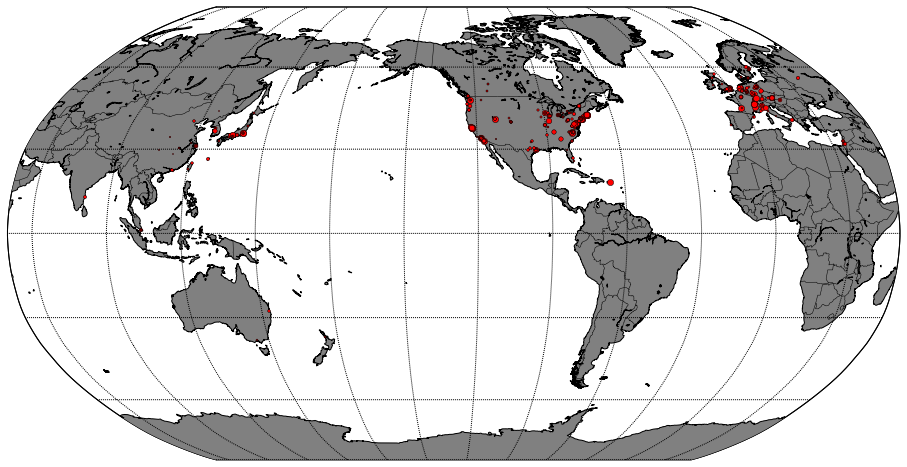

In [5]:
pub_map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
pub_map.drawcoastlines()
pub_map.drawcountries()
pub_map.fillcontinents(color = 'gray')
pub_map.drawmapboundary()
pub_map.drawmeridians(np.arange(0, 360, 30))
pub_map.drawparallels(np.arange(-90, 90, 30))
for la,lo,IF,year in plot_data:
    
    x,y = pub_map(lo, la)
    if IF is not np.nan:
        pub_map.plot(x, y,'ro', markersize= np.sqrt(IF))
plt.show()

## Analysis of the content

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
all_keywords = [ " ".join(paper['keywords']) if 'keywords' in paper else " " for paper in summary]
vectorizer = CountVectorizer(stop_words= 'english') 
text_feature = vectorizer.fit_transform(all_keywords) 
text_feature = text_feature.toarray()

In [40]:
print text_feature.shape

(1200L, 1538L)


In [44]:
vocab = vectorizer.get_feature_names()
wordcount = np.sum(text_feature, axis = 0)
sort_word_idx = np.argsort(wordcount)[::-1][:50]
for word, i in zip(np.array(vocab)[sort_word_idx],wordcount[sort_word_idx]):
    print word, 'count:', i 

optogenetics count: 317
channelrhodopsin count: 53
cortex count: 50
nucleus count: 39
imaging count: 34
stimulation count: 31
cell count: 29
electrophysiology count: 28
light count: 27
hippocampus count: 27
neural count: 26
calcium count: 25
dopamine count: 23
synaptic count: 22
circuits count: 21
amygdala count: 19
protein count: 19
prefrontal count: 19
interneuron count: 18
voltage count: 18
control count: 18
plasticity count: 17
inhibition count: 17
reward count: 17
gene count: 17
accumbens count: 16
behavior count: 16
sleep count: 16
brain count: 15
interneurons count: 15
motor count: 15
memory count: 15
optogenetic count: 15
mouse count: 15
circuit count: 15
neurons count: 14
mapping count: 14
gaba count: 14
optical count: 14
depression count: 14
biology count: 14
hypothalamus count: 14
fear count: 14
epilepsy count: 13
vivo count: 13
glutamate count: 13
cells count: 13
systems count: 12
microscopy count: 12
channels count: 12


In [49]:
# create network display of top 50 keywords
netplot_data = text_feature[:,sort_word_idx]
vocab_top = vocab[sort_word_idx]
for i in range(netplot_data.shape[0]):
    row = netplot_data[i,:]
    row.nonzero()
        

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [33]:
type(vocab)

list

In [48]:
 a = np.reshape(np.random.random_integers(0,1,size=100),(10,10))
print a

[[0 1 0 1 1 0 1 1 1 1]
 [1 1 0 0 1 0 1 0 0 0]
 [1 0 1 0 1 0 1 1 1 1]
 [0 0 0 1 1 0 0 0 1 1]
 [1 1 0 1 1 0 0 1 1 1]
 [1 0 0 1 0 1 0 1 1 0]
 [1 1 0 1 1 0 1 0 1 1]
 [1 1 1 0 1 0 0 0 1 0]
 [0 0 1 0 0 1 1 0 1 0]
 [0 1 1 1 0 1 1 1 1 1]]


In [51]:
import networkx as nx
D = nx.to_networkx_graph(a)

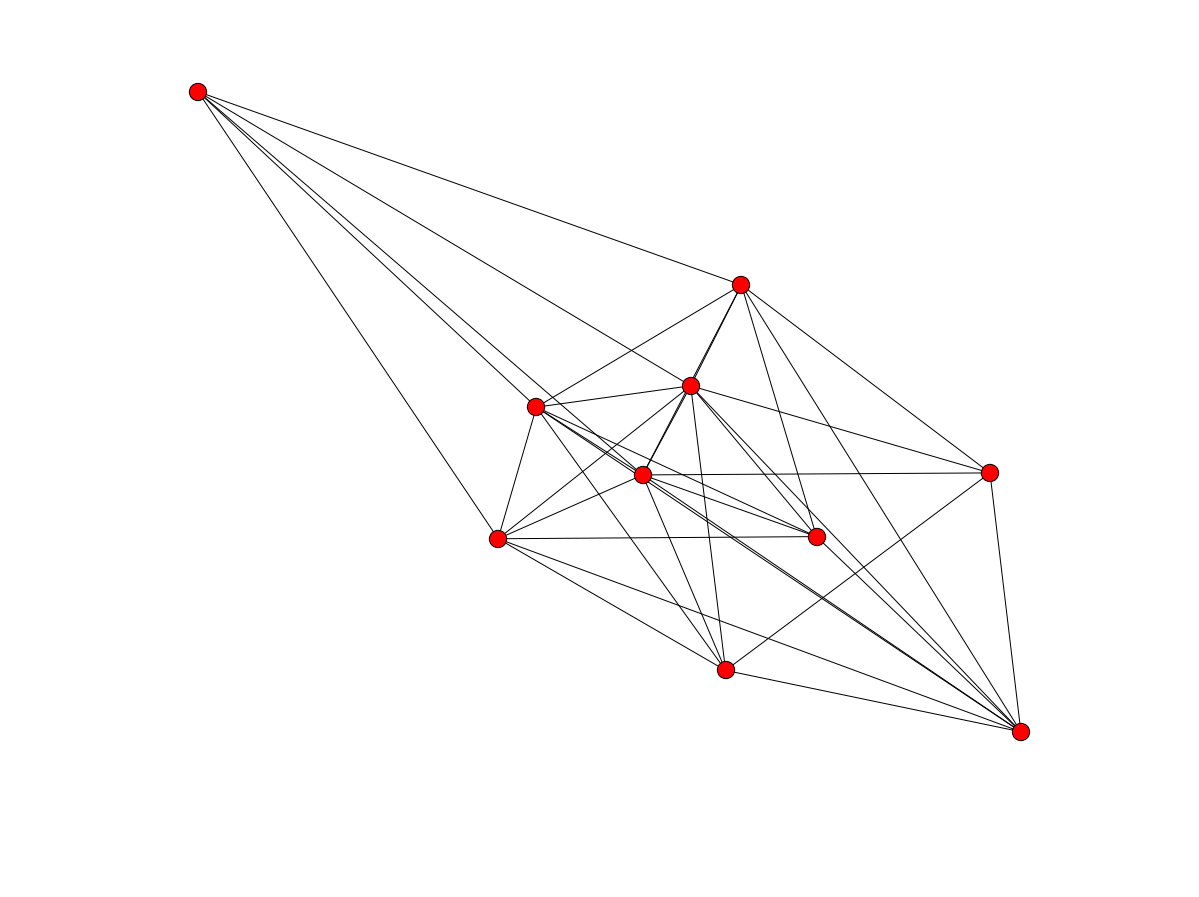

In [54]:
nx.draw(D)